In [91]:
!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

In [92]:
# Visualization settings
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
RANDOM_SEED = 42

In [93]:
# Load datasets
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

# Display basic information
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [94]:
# For categorical features with high missing percentages where NA means absence of feature
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')

# For garage-related features
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in garage_cols:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')

# For basement-related features
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in bsmt_cols:
    train_data[col] = train_data[col].fillna('None')
    test_data[col] = test_data[col].fillna('None')

In [95]:
# For numerical features, I will impute with median or 0 depending on context
train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
test_data['LotFrontage'] = test_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Fill remaining numerical missing values with 0
for col in ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageYrBlt', 'GarageArea', 'GarageCars']:
    train_data[col] = train_data[col].fillna(0)
    test_data[col] = test_data[col].fillna(0)

# Fill remaining categorical missing values with most frequent value
for col in ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(train_data[col].mode()[0])

# Fill MasVnrType with 'None' for missing values
train_data['MasVnrType'] = train_data['MasVnrType'].fillna('None')
test_data['MasVnrType'] = test_data['MasVnrType'].fillna('None')

In [96]:
# Total Square Footage
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
test_data['TotalSF'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']

# Total Bathrooms
train_data['TotalBathrooms'] = train_data['FullBath'] + (0.5 * train_data['HalfBath']) + \
                              train_data['BsmtFullBath'] + (0.5 * train_data['BsmtHalfBath'])
test_data['TotalBathrooms'] = test_data['FullBath'] + (0.5 * test_data['HalfBath']) + \
                             test_data['BsmtFullBath'] + (0.5 * test_data['BsmtHalfBath'])

# House Age and Remodeled Status
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
test_data['HouseAge'] = test_data['YrSold'] - test_data['YearBuilt']

train_data['Remodeled'] = (train_data['YearRemodAdd'] != train_data['YearBuilt']).astype(int)
test_data['Remodeled'] = (test_data['YearRemodAdd'] != test_data['YearBuilt']).astype(int)

train_data['RecentRemodel'] = (train_data['YrSold'] - train_data['YearRemodAdd']).astype(int)
test_data['RecentRemodel'] = (test_data['YrSold'] - test_data['YearRemodAdd']).astype(int)

# Total Porch Square Footage
train_data['TotalPorchSF'] = train_data['OpenPorchSF'] + train_data['EnclosedPorch'] + \
                            train_data['3SsnPorch'] + train_data['ScreenPorch']
test_data['TotalPorchSF'] = test_data['OpenPorchSF'] + test_data['EnclosedPorch'] + \
                           test_data['3SsnPorch'] + test_data['ScreenPorch']

# Overall Grade (combination of quality and condition)
train_data['OverallGrade'] = train_data['OverallQual'] * train_data['OverallCond']
test_data['OverallGrade'] = test_data['OverallQual'] * test_data['OverallCond']

In [97]:
# Has Features
train_data['HasPool'] = (train_data['PoolArea'] > 0).astype(int)
test_data['HasPool'] = (test_data['PoolArea'] > 0).astype(int)

train_data['HasGarage'] = (train_data['GarageArea'] > 0).astype(int)
test_data['HasGarage'] = (test_data['GarageArea'] > 0).astype(int)

train_data['HasFireplace'] = (train_data['Fireplaces'] > 0).astype(int)
test_data['HasFireplace'] = (test_data['Fireplaces'] > 0).astype(int)

train_data['HasBasement'] = (train_data['TotalBsmtSF'] > 0).astype(int)
test_data['HasBasement'] = (test_data['TotalBsmtSF'] > 0).astype(int)

# Neighborhood Quality (based on median SalePrice)
neighborhood_quality = train_data.groupby('Neighborhood')['SalePrice'].median().to_dict()
train_data['NeighborhoodQuality'] = train_data['Neighborhood'].map(neighborhood_quality)
test_data['NeighborhoodQuality'] = test_data['Neighborhood'].map(neighborhood_quality)

# Quality-related interactions
train_data['Qual_LivArea'] = train_data['OverallQual'] * train_data['GrLivArea']
test_data['Qual_LivArea'] = test_data['OverallQual'] * test_data['GrLivArea']

train_data['Qual_BsmtArea'] = train_data['OverallQual'] * train_data['TotalBsmtSF']
test_data['Qual_BsmtArea'] = test_data['OverallQual'] * test_data['TotalBsmtSF']

train_data['Qual_GarageArea'] = train_data['OverallQual'] * train_data['GarageArea']
test_data['Qual_GarageArea'] = test_data['OverallQual'] * test_data['GarageArea']

In [98]:
# Finding which column is causing errors
for i, col in enumerate(nominal_features):
    print(f"Column {i}: {col}")
    print(f"Test has NaN: {test_data[col].isna().any()}")
    if test_data[col].isna().any():
        print(f"Number of NaN values: {test_data[col].isna().sum()}")

Column 0: MSZoning
Test has NaN: False
Column 1: Street
Test has NaN: False
Column 2: Alley
Test has NaN: False
Column 3: LotShape
Test has NaN: False
Column 4: LandContour
Test has NaN: False
Column 5: Utilities
Test has NaN: True
Number of NaN values: 2
Column 6: LotConfig
Test has NaN: False
Column 7: LandSlope
Test has NaN: False
Column 8: Neighborhood
Test has NaN: False
Column 9: Condition1
Test has NaN: False
Column 10: Condition2
Test has NaN: False
Column 11: BldgType
Test has NaN: False
Column 12: HouseStyle
Test has NaN: False
Column 13: RoofStyle
Test has NaN: False
Column 14: RoofMatl
Test has NaN: False
Column 15: Exterior1st
Test has NaN: False
Column 16: Exterior2nd
Test has NaN: False
Column 17: MasVnrType
Test has NaN: False
Column 18: Foundation
Test has NaN: False
Column 19: BsmtExposure
Test has NaN: False
Column 20: BsmtFinType1
Test has NaN: False
Column 21: BsmtFinType2
Test has NaN: False
Column 22: Heating
Test has NaN: False
Column 23: CentralAir
Test has NaN

In [99]:
# Identifying categorical features
categorical_features = train_data.select_dtypes(include=['object']).columns

# Handling any remaining missing values in categorical features
for col in categorical_features:
    # Checking if column has missing values in test data
    if test_data[col].isna().any():
        print(f"Filling missing values in {col}")
        # Fill missing values with the most frequent value from training data
        mode_val = train_data[col].mode()[0]
        train_data[col] = train_data[col].fillna(mode_val)
        test_data[col] = test_data[col].fillna(mode_val)

# Ordinal encoding for quality features
quality_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
quality_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for col in quality_cols:
    if col in train_data.columns:
        train_data[col] = train_data[col].map(quality_map)
        test_data[col] = test_data[col].map(quality_map)

# One-hot encoding for nominal categorical features
from sklearn.preprocessing import OneHotEncoder

# Select only nominal categorical features (exclude ordinal ones already encoded)
nominal_features = [col for col in categorical_features if col not in quality_cols]

# Double-checking for any remaining NaN values
for col in nominal_features:
    if train_data[col].isna().any() or test_data[col].isna().any():
        print(f"WARNING: {col} still has NaN values. Filling with mode.")
        mode_val = train_data[col].mode()[0]
        train_data[col] = train_data[col].fillna(mode_val)
        test_data[col] = test_data[col].fillna(mode_val)

# Applying one-hot encoding with handle_unknown='ignore' for more robustness
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
train_nominal_encoded = encoder.fit_transform(train_data[nominal_features])
test_nominal_encoded = encoder.transform(test_data[nominal_features])

# Creating DataFrames with encoded feature names
encoded_feature_names = encoder.get_feature_names_out(nominal_features)
train_nominal_df = pd.DataFrame(train_nominal_encoded, columns=encoded_feature_names, index=train_data.index)
test_nominal_df = pd.DataFrame(test_nominal_encoded, columns=encoded_feature_names, index=test_data.index)

# Concatenating with original dataframes (excluding original nominal features)
train_data = pd.concat([train_data.drop(nominal_features, axis=1), train_nominal_df], axis=1)
test_data = pd.concat([test_data.drop(nominal_features, axis=1), test_nominal_df], axis=1)

Filling missing values in Utilities
Filling missing values in Functional


SalePrice_Log column not found. Creating it now.
Selected 55 features based on correlation threshold of 0.3
['OverallQual', 'Qual_LivArea', 'Qual_GarageArea', 'TotalSF', 'NeighborhoodQuality', 'Qual_BsmtArea', 'GrLivArea', 'GarageCars', 'ExterQual', 'TotalBathrooms', 'KitchenQual', 'GarageArea', 'BsmtQual', 'TotalBsmtSF', 'OverallGrade', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'FireplaceQu', 'TotRmsAbvGrd', 'Foundation_PConc', 'HasFireplace', 'Fireplaces', 'HeatingQC', 'BsmtFinType1_GLQ', 'MasVnrArea', 'GarageType_Attchd', 'BsmtFinSF1', 'GarageQual', 'GarageCond', 'LotFrontage', 'Neighborhood_NridgHt', 'CentralAir_Y', 'GarageYrBlt', 'Exterior2nd_VinylSd', 'Exterior1st_VinylSd', 'WoodDeckSF', 'SaleType_New', 'SaleCondition_Partial', 'HasGarage', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'MasVnrType_Stone', 'Electrical_SBrkr', 'GarageFinish_None', 'GarageType_None', 'Foundation_CBlock', 'MSZoning_RM', 'MasVnrType_None', 'GarageType_Detchd', 'GarageFinish_Unf', 'RecentRemodel', 

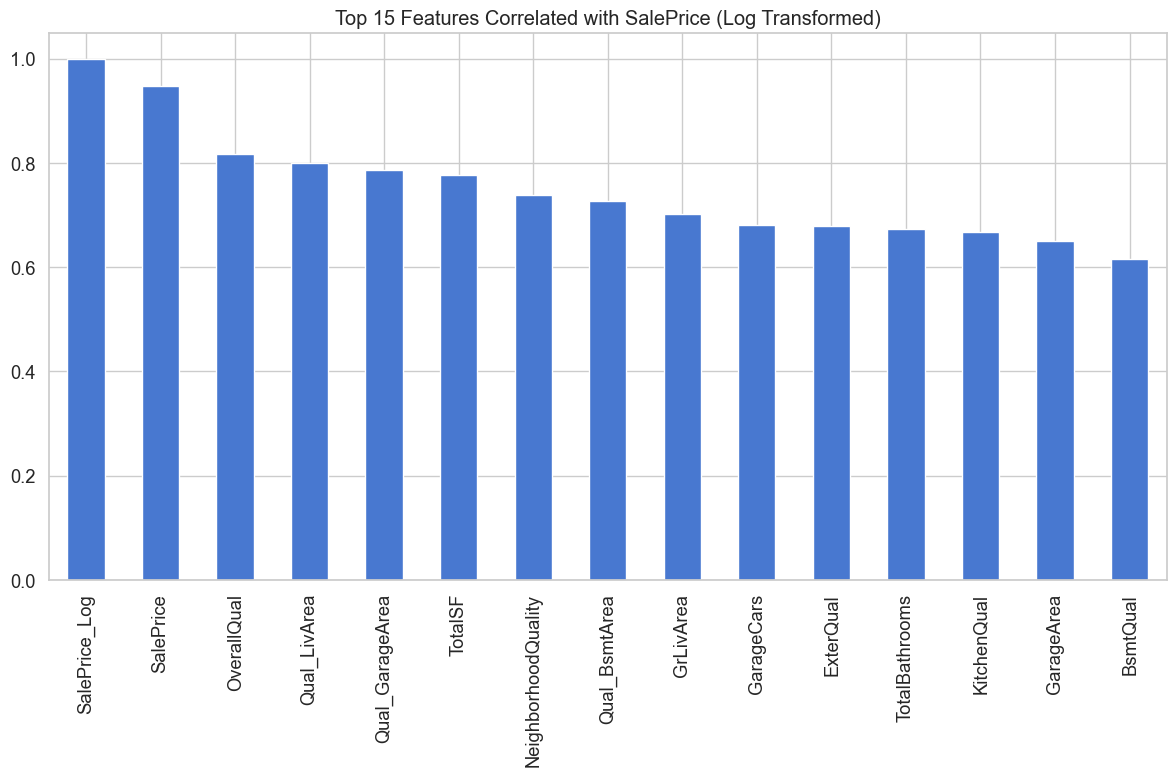

In [100]:
# Check if SalePrice_Log exists since I am getting an error
if 'SalePrice_Log' not in train_data.columns:
    print("SalePrice_Log column not found. Creating it now.")
    train_data['SalePrice_Log'] = np.log1p(train_data['SalePrice'])

# Calculatng correlation with SalePrice_Log
correlations = train_data.corr()['SalePrice_Log'].sort_values(ascending=False)

# Selecting top features based on correlation threshold
correlation_threshold = 0.3
corr_features = correlations[abs(correlations) > correlation_threshold].index.tolist()
corr_features.remove('SalePrice_Log')  # Remove target variable
if 'SalePrice' in corr_features:
    corr_features.remove('SalePrice')  # Remove original target variable

print(f"Selected {len(corr_features)} features based on correlation threshold of {correlation_threshold}")
print(corr_features)

# Visualizing top correlations
plt.figure(figsize=(12, 8))
top_corr = correlations[0:15]  # Top 15 correlations
top_corr.plot(kind='bar')
plt.title('Top 15 Features Correlated with SalePrice (Log Transformed)')
plt.tight_layout()
plt.show()

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = train_data[corr_features]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by VIF value
vif_data = vif_data.sort_values('VIF', ascending=False)
print(vif_data)

# Remove features with high VIF (indicating multicollinearity)
high_vif_threshold = 10
high_vif_features = vif_data[vif_data["VIF"] > high_vif_threshold]["Feature"].tolist()
print(f"Features with high VIF (> {high_vif_threshold}):")
print(high_vif_features)

# Remove high VIF features from selection
selected_features = [feat for feat in corr_features if feat not in high_vif_features]
print(f"Selected {len(selected_features)} features after removing high VIF features")

                  Feature           VIF
3                 TotalSF           inf
18           YearRemodAdd           inf
13            TotalBsmtSF           inf
15               1stFlrSF           inf
17              YearBuilt           inf
54               HouseAge           inf
47        GarageType_None           inf
53          RecentRemodel           inf
46      GarageFinish_None           inf
42               2ndFlrSF           inf
40              HasGarage  2.352538e+06
34            GarageYrBlt  1.696474e+03
6               GrLivArea  1.645376e+02
1            Qual_LivArea  7.412494e+01
2         Qual_GarageArea  6.407448e+01
5           Qual_BsmtArea  6.074413e+01
11             GarageArea  4.134948e+01
38           SaleType_New  3.926917e+01
39  SaleCondition_Partial  3.905156e+01
36    Exterior1st_VinylSd  2.406401e+01
35    Exterior2nd_VinylSd  2.378532e+01
22           HasFireplace  1.789530e+01
29             GarageQual  1.690684e+01
30             GarageCond  1.682929e+01


Top 20 features by importance:
                Feature  Importance
1          Qual_LivArea    0.552601
5         Qual_BsmtArea    0.079775
2       Qual_GarageArea    0.070643
3               TotalSF    0.070052
4   NeighborhoodQuality    0.050150
0           OverallQual    0.025688
14         OverallGrade    0.015731
28           BsmtFinSF1    0.014210
9        TotalBathrooms    0.009740
15             1stFlrSF    0.008018
53        RecentRemodel    0.007545
6             GrLivArea    0.007523
31          LotFrontage    0.006183
49          MSZoning_RM    0.006095
54             HouseAge    0.006057
33         CentralAir_Y    0.005447
11           GarageArea    0.005214
13          TotalBsmtSF    0.005105
17            YearBuilt    0.004976
18         YearRemodAdd    0.004313


<Figure size 1200x800 with 0 Axes>

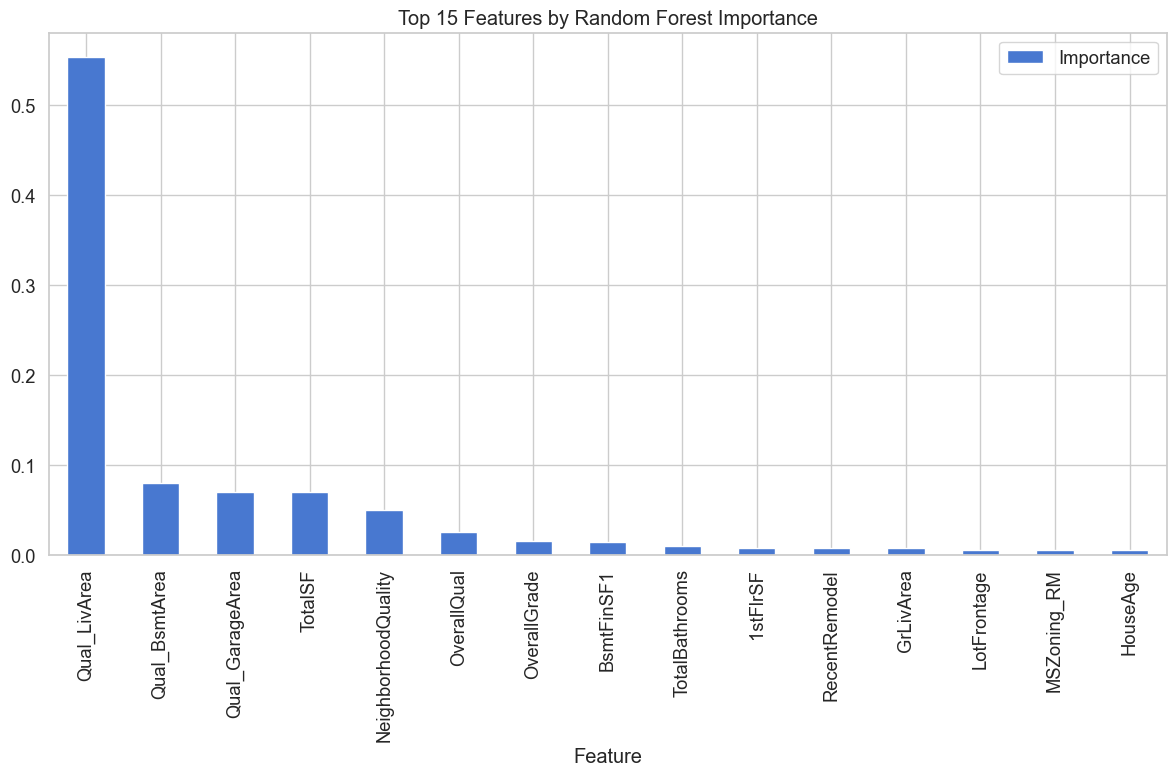

Selected 8 features based on importance threshold of 0.01


In [102]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_data[corr_features], train_data['SalePrice_Log'])

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': corr_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 features by importance:")
print(feature_importances.head(20))

# Visualize feature importances
plt.figure(figsize=(12, 8))
feature_importances.head(15).plot(kind='bar', x='Feature', y='Importance')
plt.title('Top 15 Features by Random Forest Importance')
plt.tight_layout()
plt.show()

# Select top features based on importance threshold
importance_threshold = 0.01
important_features = feature_importances[feature_importances['Importance'] > importance_threshold]['Feature'].tolist()
print(f"Selected {len(important_features)} features based on importance threshold of {importance_threshold}")

Best alpha: 0.0006
Selected 44 features using Lasso
['OverallQual', 'Qual_LivArea', 'Qual_GarageArea', 'TotalSF', 'NeighborhoodQuality', 'Qual_BsmtArea', 'GrLivArea', 'GarageCars', 'ExterQual', 'TotalBathrooms', 'KitchenQual', 'BsmtQual', 'TotalBsmtSF', 'OverallGrade', '1stFlrSF', 'FullBath', 'FireplaceQu', 'TotRmsAbvGrd', 'Foundation_PConc', 'HasFireplace', 'Fireplaces', 'HeatingQC', 'BsmtFinType1_GLQ', 'MasVnrArea', 'GarageType_Attchd', 'BsmtFinSF1', 'GarageQual', 'GarageCond', 'LotFrontage', 'Neighborhood_NridgHt', 'CentralAir_Y', 'GarageYrBlt', 'Exterior2nd_VinylSd', 'WoodDeckSF', 'SaleType_New', 'OpenPorchSF', 'MasVnrType_Stone', 'Electrical_SBrkr', 'Foundation_CBlock', 'MSZoning_RM', 'MasVnrType_None', 'GarageFinish_Unf', 'RecentRemodel', 'HouseAge']


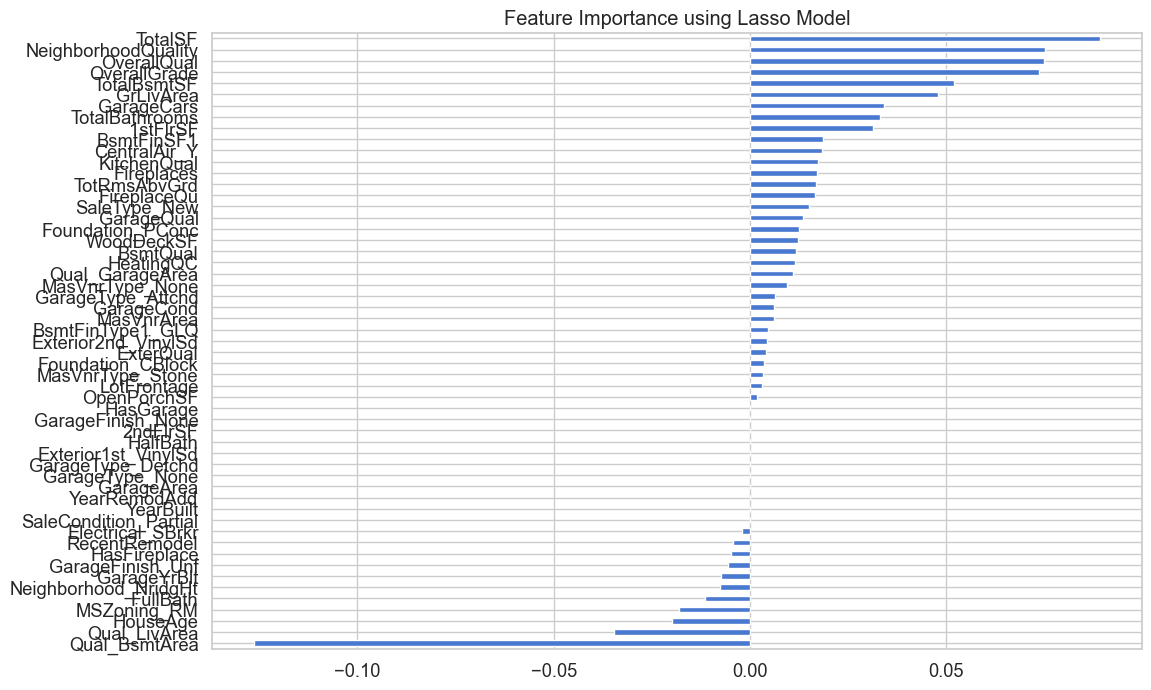

In [103]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_data[corr_features])
X_scaled_df = pd.DataFrame(X_scaled, columns=corr_features)

# Applying Lasso with cross-validation to find optimal alpha
lasso_cv = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                          0.3, 0.6, 1],
                  max_iter=50000, cv=5)
lasso_cv.fit(X_scaled_df, train_data['SalePrice_Log'])
print(f"Best alpha: {lasso_cv.alpha_}")

# Applying Lasso with the best alpha
lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=50000)
lasso.fit(X_scaled_df, train_data['SalePrice_Log'])

# Getting selected features (non-zero coefficients)
lasso_selected_features = [corr_features[i] for i in range(len(corr_features)) if lasso.coef_[i] != 0]
print(f"Selected {len(lasso_selected_features)} features using Lasso")
print(lasso_selected_features)

# Plot feature coefficients
coef = pd.Series(lasso.coef_, index=corr_features)
imp_coef = coef.sort_values()
plt.figure(figsize=(12, 8))
imp_coef.plot(kind="barh")
plt.title("Feature Importance using Lasso Model")
plt.show()

In [104]:
# Combine features selected by different methods
from functools import reduce
from collections import Counter

all_selected_features = [
    set(corr_features),
    set(selected_features),  # After VIF filtering
    set(important_features),
    set(lasso_selected_features)
]

# Find features selected by at least 2 methods
all_features_flat = [feat for sublist in all_selected_features for feat in sublist]
feature_counts = Counter(all_features_flat)
final_features = [feat for feat, count in feature_counts.items() if count >= 2]
print(f"Final feature set (selected by at least 2 methods): {len(final_features)}")
print(final_features)

# Create final training and test datasets with selected features
X_train_final = train_data[final_features]
y_train = train_data['SalePrice_Log']
X_test_final = test_data[final_features]

# Save the final datasets for modeling
X_train_final.to_csv('../data/X_train_final.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
X_test_final.to_csv('../data/X_test_final.csv', index=False)

Final feature set (selected by at least 2 methods): 46
['GarageCond', 'RecentRemodel', 'SaleType_New', 'WoodDeckSF', 'HalfBath', 'TotalBsmtSF', 'CentralAir_Y', 'Foundation_PConc', 'OverallQual', 'GarageYrBlt', 'GarageQual', 'Electrical_SBrkr', 'ExterQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType_Attchd', 'FireplaceQu', 'MasVnrType_None', 'Exterior2nd_VinylSd', 'Foundation_CBlock', 'TotalBathrooms', 'MasVnrArea', 'BsmtQual', 'NeighborhoodQuality', 'KitchenQual', 'FullBath', 'HasFireplace', 'HeatingQC', 'Qual_LivArea', '1stFlrSF', 'Qual_GarageArea', 'OverallGrade', 'GarageType_Detchd', 'GarageFinish_Unf', 'HouseAge', 'GarageCars', 'BsmtFinType1_GLQ', 'TotalSF', 'Qual_BsmtArea', 'MSZoning_RM', 'Neighborhood_NridgHt', 'GrLivArea', 'OpenPorchSF', 'LotFrontage', 'BsmtFinSF1', 'MasVnrType_Stone']


In [105]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to evaluate model with RMSE
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

# Baseline model with original features (top 15 correlated numerical features)
original_num_features = train_data.select_dtypes(include=['int64', 'float64']).columns
original_num_features = [col for col in original_num_features if col != 'Id' and col != 'SalePrice' and col != 'SalePrice_Log']
corr = train_data[original_num_features + ['SalePrice_Log']].corr()['SalePrice_Log'].sort_values(ascending=False)
original_top_features = corr[1:16].index.tolist()  # Top 15 excluding SalePrice

# Model with original features
model_original = ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42)
rmse_original = rmse_cv(model_original, train_data[original_top_features], train_data['SalePrice_Log'])
print(f"RMSE with original features: {rmse_original.mean():.4f} (±{rmse_original.std():.4f})")

# Model with engineered and selected features
model_engineered = ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42)
rmse_engineered = rmse_cv(model_engineered, X_train_final, y_train)
print(f"RMSE with engineered features: {rmse_engineered.mean():.4f} (±{rmse_engineered.std():.4f})")

# Improvement percentage
improvement = (rmse_original.mean() - rmse_engineered.mean()) / rmse_original.mean() * 100
print(f"Improvement: {improvement:.2f}%")

RMSE with original features: 0.1521 (±0.0117)
RMSE with engineered features: 0.1458 (±0.0217)
Improvement: 4.10%


I explored the dataset to understand what makes homes more valuable. After cleaning up missing information and looking at relationships between features, I transformed the data to make it more useful for prediction.

Creating New Features
I combined existing measurements to create more meaningful indicators:

Combined different floor areas to get the total house size
Created a bathroom count that includes all types
Calculated how old houses are and whether they've been updated
Made features that combine quality ratings with size measurements
Handling Skewed Data
Many numerical features weren't evenly distributed (they were "skewed"). I applied log transformations to make them more balanced, which helps prediction models work better. I also transformed the house prices themselves since they were skewed too.

Converting Categorical Features
I handled text-based features in two ways:

For features with a natural order (like quality ratings from Poor to Excellent), I converted them to numbers
For features without order (like neighborhood names), I used one-hot encoding to create separate columns
Challenges I Faced
Missing Values in Test Data
When trying to encode categorical features, I hit an error because the test data contained missing values that weren't in the training data. The error message was:
             ValueError: Found unknown categories [nan] in column 5 during transform
This happened because the encoder was trained on the training data but encountered new values (NaN) in the test data.

Missing SalePrice_Log Column
When trying to calculate correlations, I got this error:
             KeyError: 'SalePrice_Log'
This happened because I created the log-transformed price column earlier, but it got lost during one of the data transformation steps.

How I Fixed These Issues
 For the Missing Values Error:
 I added code to:
   Check for and fill missing values in all categorical features before encoding
   Set the encoder to ignore unknown categories with handle_unknown='ignore'
   Print diagnostic information to understand which columns had issues

 For the Missing Column Error:
   I added a check to see if the column exists, and if not, recreate it:
python
Copy Code
if 'SalePrice_Log' not in train_data.columns:
    train_data['SalePrice_Log'] = np.log1p(train_data['SalePrice'])

What I Learned
Feature engineering requires:
  Understanding the data and what each feature represents
  Being careful about how transformations affect your dataset
  Checking your data at each step to catch problems early
  Handling training and test data consistently
The most important features for house prices turned out to be overall quality, living area, garage size, and neighborhood quality. I also found that engineered features like total square footage and quality-size combinations were strongly related to house prices.

These insights will help build a more accurate prediction model in the next phase of the project.